# Imports

In [1]:
import scipy as sp
import matplotlib.pylab as plt
import os

import cv2

%matplotlib notebook

# Instanciate Class and small demos

In [2]:
# Test Model Builder Class
import model

mydata = model.DriveData()

2018-12-10 13:46:57,576 - model - DEBUG - DriveData._load_csv: Load csv file


In [3]:
mydata._samples['center'][0]

'IMG/center_2016_12_01_13_30_48_287.jpg'

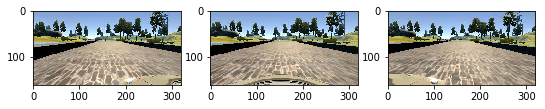

In [4]:
plt.figure(figsize=(9,3))

plt.subplot(131)
image = plt.imread(os.path.join('./data',mydata._samples['left'][0].lstrip()))
plt.imshow(image)

plt.subplot(132)
image = plt.imread(os.path.join('./data',mydata._samples['center'][0]))
plt.imshow(image)

plt.subplot(133)
image = plt.imread(os.path.join('./data',mydata._samples['right'][0].lstrip()))
plt.imshow(image)



In [5]:
mydata._samples

,center,left,right,steering,throttle,brake,speed,im_sel,im_manip
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290,center,none
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630,center,none
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011,center,none
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419,center,none
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236,center,none
5,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993,center,none
6,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892,center,none
7,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934,center,none
8,IMG/center_2016_12_01_13_31_13_584.jpg,IMG/left_2016_12_01_13_31_13_584.jpg,IMG/right_2016_12_01_13_31_13_584.jpg,0.0,0.0,0.0,1.362115,center,none
9,IMG/center_2016_12_01_13_31_13_686.jpg,IMG/left_2016_12_01_13_31_13_686.jpg,IMG/right_2016_12_01_13_31_13_686.jpg,0.0,0.0,0.0,1.348435,center,none


In [6]:
X, Y = next(mydata.generator_train)

 Generate batch data
--------------------------------------------------
 Batch size = 32, Sample Size = 6428


In [7]:
X.shape

(32, 160, 320, 3)

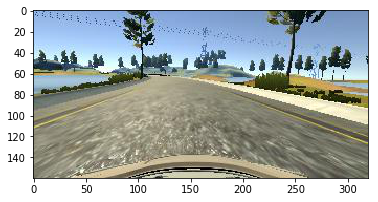

In [8]:
plt.figure()

plt.imshow(X[4,:,:,:])